# Pulse Propagation Pattern Search

This notebook searches for optimal lattice patterns combined with different pulse propagation types.
We evaluate how different pattern initializations perform when signals propagate through the lattice.

## Overview
1. Define pulse propagation types (decay rates, step counts, bounce behaviors)
2. Define pattern search space
3. Create propagation-aware lattice autoencoder
4. Search for optimal pattern × propagation combinations
5. Train final model with best configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any
from collections import defaultdict
import time
from tqdm.auto import tqdm
import itertools

# Local imports
from tensor_lattice import Tensor3DLattice, DifferentiableTensor3DLattice
from lattice_patterns import PatternGenerator, Pattern3D

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


## 1. Configuration

In [2]:
# Lattice configuration
LATTICE_SHAPE = (12, 12, 12)  # Smaller for faster search with propagation
TOPOLOGY = 'toroidal'
CONNECTIVITY = '6-connected'

# Model configuration
INPUT_DIM = 784  # MNIST flattened
OUTPUT_DIM = 784
HIDDEN_DIM = 256

# Search configuration
TRAIN_EPOCHS = 8  # Quick training per candidate
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

# Create pattern generator
pg = PatternGenerator(shape=LATTICE_SHAPE)

print(f"Lattice shape: {LATTICE_SHAPE}")
print(f"Total cells: {np.prod(LATTICE_SHAPE)}")

Lattice shape: (12, 12, 12)
Total cells: 1728


## 2. Define Pulse Propagation Types

In [3]:
@dataclass
class PropagationType:
    """Configuration for a pulse propagation type."""
    name: str
    n_steps: int  # Number of propagation steps
    decay_rate: float  # Signal decay per step
    bounce_strength: float  # How much bounce angles affect propagation
    diffusion_rate: float  # How much signal spreads to neighbors
    self_retention: float  # How much signal stays in current cell
    nonlinearity: str  # 'relu', 'tanh', 'sigmoid', 'none'
    
    def __hash__(self):
        return hash(self.name)


# Define different propagation types
PROPAGATION_TYPES = {
    # Fast, minimal spreading
    'sharp': PropagationType(
        name='sharp',
        n_steps=3,
        decay_rate=0.95,
        bounce_strength=0.1,
        diffusion_rate=0.2,
        self_retention=0.8,
        nonlinearity='relu'
    ),
    
    # Medium spread, moderate decay
    'diffuse': PropagationType(
        name='diffuse',
        n_steps=5,
        decay_rate=0.85,
        bounce_strength=0.3,
        diffusion_rate=0.5,
        self_retention=0.5,
        nonlinearity='tanh'
    ),
    
    # Long-range propagation
    'wave': PropagationType(
        name='wave',
        n_steps=8,
        decay_rate=0.9,
        bounce_strength=0.5,
        diffusion_rate=0.6,
        self_retention=0.4,
        nonlinearity='tanh'
    ),
    
    # Oscillating with high bounce
    'resonant': PropagationType(
        name='resonant',
        n_steps=6,
        decay_rate=0.92,
        bounce_strength=0.8,
        diffusion_rate=0.4,
        self_retention=0.6,
        nonlinearity='tanh'
    ),
    
    # Slow, preserving
    'persistent': PropagationType(
        name='persistent',
        n_steps=10,
        decay_rate=0.98,
        bounce_strength=0.2,
        diffusion_rate=0.3,
        self_retention=0.7,
        nonlinearity='sigmoid'
    ),
    
    # Rapid spreading, quick decay
    'explosive': PropagationType(
        name='explosive',
        n_steps=4,
        decay_rate=0.7,
        bounce_strength=0.4,
        diffusion_rate=0.8,
        self_retention=0.2,
        nonlinearity='relu'
    ),
    
    # No propagation baseline
    'static': PropagationType(
        name='static',
        n_steps=0,
        decay_rate=1.0,
        bounce_strength=0.0,
        diffusion_rate=0.0,
        self_retention=1.0,
        nonlinearity='none'
    ),
}

print(f"Defined {len(PROPAGATION_TYPES)} propagation types:")
for name, ptype in PROPAGATION_TYPES.items():
    print(f"  - {name}: {ptype.n_steps} steps, decay={ptype.decay_rate}, diffusion={ptype.diffusion_rate}")

Defined 7 propagation types:
  - sharp: 3 steps, decay=0.95, diffusion=0.2
  - diffuse: 5 steps, decay=0.85, diffusion=0.5
  - wave: 8 steps, decay=0.9, diffusion=0.6
  - resonant: 6 steps, decay=0.92, diffusion=0.4
  - persistent: 10 steps, decay=0.98, diffusion=0.3
  - explosive: 4 steps, decay=0.7, diffusion=0.8
  - static: 0 steps, decay=1.0, diffusion=0.0


## 3. Define Pattern Search Space

In [4]:
@dataclass
class PatternConfig:
    """Configuration for a pattern."""
    name: str
    pattern: Pattern3D
    
    def __hash__(self):
        return hash(self.name)


# Define patterns optimized for propagation
PATTERNS = {
    # Geometric
    'sphere': PatternConfig('sphere', pg.sphere(radius=0.4)),
    'shell': PatternConfig('shell', pg.shell(inner_radius=0.25, outer_radius=0.45)),
    'cube': PatternConfig('cube', pg.cube(size=0.6)),
    
    # Gradients - good for directional propagation
    'grad_z': PatternConfig('grad_z', pg.gradient(axis='z')),
    'grad_radial': PatternConfig('grad_radial', pg.radial_gradient()),
    'grad_radial_inv': PatternConfig('grad_radial_inv', pg.radial_gradient().invert()),
    
    # Waves - natural for propagation
    'wave_z': PatternConfig('wave_z', pg.sine_wave(frequency=(0, 0, 2))),
    'wave_xyz': PatternConfig('wave_xyz', pg.sine_wave(frequency=(1, 1, 1))),
    'spherical_wave': PatternConfig('spherical_wave', pg.spherical_wave(frequency=2)),
    'spiral': PatternConfig('spiral', pg.spiral(turns=2)),
    
    # Structured - for channeled propagation
    'grid': PatternConfig('grid', pg.grid_lines(spacing=3, thickness=1)),
    'checkerboard': PatternConfig('checkerboard', pg.checkerboard(cell_size=3)),
    
    # Special surfaces
    'gyroid': PatternConfig('gyroid', pg.gyroid(scale=2.0)),
    
    # Noise - for stochastic propagation
    'noise': PatternConfig('noise', pg.noise(scale=0.5)),
    
    # Uniform baseline
    'uniform': PatternConfig('uniform', pg.ones()),
}

print(f"Defined {len(PATTERNS)} patterns:")
for name in PATTERNS:
    print(f"  - {name}")

Defined 15 patterns:
  - sphere
  - shell
  - cube
  - grad_z
  - grad_radial
  - grad_radial_inv
  - wave_z
  - wave_xyz
  - spherical_wave
  - spiral
  - grid
  - checkerboard
  - gyroid
  - noise
  - uniform


## 4. Propagation-Aware Lattice Model

In [5]:
class PulsePropagationLattice(nn.Module):
    """Lattice with configurable pulse propagation."""
    
    def __init__(self, shape: Tuple[int, ...], topology: str = 'toroidal',
                 connectivity: str = '6-connected'):
        super().__init__()
        self.shape = shape
        self.n_cells = np.prod(shape)
        
        # Build adjacency matrix based on connectivity
        self.register_buffer('adjacency', self._build_adjacency(shape, topology, connectivity))
    
    def _build_adjacency(self, shape: Tuple[int, ...], topology: str, 
                         connectivity: str) -> torch.Tensor:
        """Build normalized adjacency matrix."""
        d1, d2, d3 = shape
        n_cells = d1 * d2 * d3
        adjacency = torch.zeros(n_cells, n_cells)
        
        # Define neighbor offsets based on connectivity
        if connectivity == '6-connected':
            offsets = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
        elif connectivity == '18-connected':
            offsets = [(i,j,k) for i in [-1,0,1] for j in [-1,0,1] for k in [-1,0,1]
                      if abs(i)+abs(j)+abs(k) <= 2 and (i,j,k) != (0,0,0)]
        else:  # 26-connected
            offsets = [(i,j,k) for i in [-1,0,1] for j in [-1,0,1] for k in [-1,0,1]
                      if (i,j,k) != (0,0,0)]
        
        for x in range(d1):
            for y in range(d2):
                for z in range(d3):
                    idx = x * d2 * d3 + y * d3 + z
                    
                    for dx, dy, dz in offsets:
                        if topology == 'toroidal':
                            nx, ny, nz = (x+dx) % d1, (y+dy) % d2, (z+dz) % d3
                        elif topology == 'bounded':
                            nx, ny, nz = x+dx, y+dy, z+dz
                            if not (0 <= nx < d1 and 0 <= ny < d2 and 0 <= nz < d3):
                                continue
                        else:  # cylindrical
                            nx, ny = (x+dx) % d1, (y+dy) % d2
                            nz = z + dz
                            if not (0 <= nz < d3):
                                continue
                        
                        neighbor_idx = nx * d2 * d3 + ny * d3 + nz
                        adjacency[idx, neighbor_idx] = 1.0
        
        # Normalize rows
        row_sums = adjacency.sum(dim=1, keepdim=True).clamp(min=1)
        adjacency = adjacency / row_sums
        
        return adjacency
    
    def propagate(self, state: torch.Tensor, prop_type: PropagationType,
                  pattern_weights: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """Propagate signal through lattice according to propagation type."""
        history = [state]
        
        if prop_type.n_steps == 0:
            return state * pattern_weights, history
        
        # Apply pattern modulation
        state = state * pattern_weights
        
        for step in range(prop_type.n_steps):
            # Compute diffusion to neighbors
            diffused = torch.matmul(state, self.adjacency.T)
            
            # Mix self-retention and diffusion
            state = (prop_type.self_retention * state + 
                    prop_type.diffusion_rate * diffused)
            
            # Apply decay
            state = state * prop_type.decay_rate
            
            # Apply bounce effect (pattern-modulated)
            if prop_type.bounce_strength > 0:
                bounce_factor = 1.0 + prop_type.bounce_strength * (pattern_weights - 0.5)
                state = state * bounce_factor
            
            # Apply nonlinearity
            if prop_type.nonlinearity == 'relu':
                state = F.relu(state)
            elif prop_type.nonlinearity == 'tanh':
                state = torch.tanh(state)
            elif prop_type.nonlinearity == 'sigmoid':
                state = torch.sigmoid(state)
            
            history.append(state)
        
        return state, history


class PropagationAutoencoder(nn.Module):
    """Autoencoder with pulse propagation through pattern-modulated lattice."""
    
    def __init__(self, input_dim: int, output_dim: int,
                 lattice_shape: Tuple[int, ...], hidden_dim: int = 256,
                 pattern: Pattern3D = None,
                 prop_type: PropagationType = None):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        self.prop_type = prop_type or PROPAGATION_TYPES['diffuse']
        
        # Lattice with propagation
        self.lattice = PulsePropagationLattice(lattice_shape, TOPOLOGY, CONNECTIVITY)
        
        # Pattern weights
        if pattern is not None:
            weights = torch.from_numpy(pattern.data).float().flatten()
        else:
            weights = torch.ones(self.n_cells)
        self.register_buffer('pattern_weights', weights)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, self.n_cells),
            nn.Sigmoid()
        )
        
        # Decoder - takes propagated state
        # Input includes both initial and final state for skip connection
        self.decoder = nn.Sequential(
            nn.Linear(self.n_cells * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor]]:
        """Forward pass with propagation."""
        # Encode to lattice activations
        initial_state = self.encoder(x)
        
        # Propagate through lattice
        final_state, history = self.lattice.propagate(
            initial_state, self.prop_type, self.pattern_weights
        )
        
        # Decode with skip connection
        combined = torch.cat([initial_state, final_state], dim=-1)
        reconstruction = self.decoder(combined)
        
        return reconstruction, final_state, history


print("Model classes defined!")

Model classes defined!


## 5. Load Data

In [6]:
def load_mnist_data():
    """Load MNIST data."""
    try:
        from torchvision import datasets, transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.view(-1))
        ])
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
        print(f"Loaded MNIST: {train_data.shape}")
        return train_data
    except Exception as e:
        print(f"Could not load MNIST ({e}), creating synthetic data")
        # Create synthetic multi-modal data
        n_samples = 5000
        data = torch.randn(n_samples, INPUT_DIM) * 0.3 + 0.5
        data = torch.clamp(data, 0, 1)
        return data

train_data = load_mnist_data()
print(f"Data range: [{train_data.min():.3f}, {train_data.max():.3f}]")

Loaded MNIST: torch.Size([60000, 784])
Data range: [0.000, 1.000]


## 6. Evaluation Function

In [7]:
def evaluate_configuration(pattern_config: PatternConfig,
                          prop_type: PropagationType,
                          train_data: torch.Tensor,
                          epochs: int = TRAIN_EPOCHS,
                          verbose: bool = False) -> Dict[str, float]:
    """Evaluate a pattern + propagation configuration."""
    
    model = PropagationAutoencoder(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        lattice_shape=LATTICE_SHAPE,
        hidden_dim=HIDDEN_DIM,
        pattern=pattern_config.pattern,
        prop_type=prop_type
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    
    n_samples = len(train_data)
    losses = []
    
    model.train()
    for epoch in range(epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0.0
        n_batches = 0
        
        for i in range(0, n_samples, BATCH_SIZE):
            batch_idx = indices[i:i+BATCH_SIZE]
            batch = train_data[batch_idx].to(device)
            
            optimizer.zero_grad()
            reconstruction, _, _ = model(batch)
            loss = F.mse_loss(reconstruction, batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        scheduler.step()
        losses.append(epoch_loss / n_batches)
        
        if verbose and (epoch + 1) % 3 == 0:
            print(f"  Epoch {epoch+1}: {losses[-1]:.6f}")
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        eval_data = train_data[:1000].to(device)
        reconstruction, final_state, history = model(eval_data)
        final_mse = F.mse_loss(reconstruction, eval_data).item()
        
        # Compute propagation metrics
        state_variance = final_state.var().item()
        state_sparsity = (final_state < 0.1).float().mean().item()
    
    return {
        'mse': final_mse,
        'final_loss': losses[-1],
        'state_variance': state_variance,
        'state_sparsity': state_sparsity
    }


print("Evaluation function defined!")

Evaluation function defined!


## 7. Grid Search Over Patterns × Propagation Types

In [8]:
@dataclass
class SearchResult:
    """Result from evaluating a configuration."""
    pattern_name: str
    prop_name: str
    mse: float
    final_loss: float
    state_variance: float
    state_sparsity: float
    
    def __lt__(self, other):
        return self.mse < other.mse


def run_grid_search(patterns: Dict[str, PatternConfig],
                    prop_types: Dict[str, PropagationType],
                    train_data: torch.Tensor) -> List[SearchResult]:
    """Run grid search over all pattern × propagation combinations."""
    
    results = []
    total = len(patterns) * len(prop_types)
    
    print(f"Running grid search: {len(patterns)} patterns × {len(prop_types)} propagation types = {total} combinations")
    print("=" * 70)
    
    with tqdm(total=total, desc="Grid Search") as pbar:
        for pattern_name, pattern_config in patterns.items():
            for prop_name, prop_type in prop_types.items():
                pbar.set_description(f"{pattern_name} × {prop_name}")
                
                metrics = evaluate_configuration(
                    pattern_config, prop_type, train_data
                )
                
                result = SearchResult(
                    pattern_name=pattern_name,
                    prop_name=prop_name,
                    mse=metrics['mse'],
                    final_loss=metrics['final_loss'],
                    state_variance=metrics['state_variance'],
                    state_sparsity=metrics['state_sparsity']
                )
                results.append(result)
                pbar.update(1)
    
    # Sort by MSE
    results.sort()
    
    return results


print("Grid search function defined!")

Grid search function defined!


In [9]:
# Run the search
print("Starting grid search...")
print(f"Estimated time: ~{len(PATTERNS) * len(PROPAGATION_TYPES) * TRAIN_EPOCHS * 0.3:.0f} seconds\n")

start_time = time.time()
search_results = run_grid_search(PATTERNS, PROPAGATION_TYPES, train_data)
elapsed = time.time() - start_time

print(f"\nSearch completed in {elapsed:.1f} seconds")

Starting grid search...
Estimated time: ~252 seconds

Running grid search: 15 patterns × 7 propagation types = 105 combinations


Grid Search:   0%|          | 0/105 [00:00<?, ?it/s]


Search completed in 2594.6 seconds


## 8. Analyze Results

In [10]:
# Display top results
print("\nTop 15 Configurations:")
print("=" * 70)
print(f"{'Rank':<5} {'Pattern':<20} {'Propagation':<15} {'MSE':<12} {'Variance':<10}")
print("-" * 70)

for i, result in enumerate(search_results[:15]):
    print(f"{i+1:<5} {result.pattern_name:<20} {result.prop_name:<15} {result.mse:<12.6f} {result.state_variance:<10.4f}")

best = search_results[0]
print(f"\n{'='*70}")
print(f"Best: {best.pattern_name} × {best.prop_name} (MSE: {best.mse:.6f})")


Top 15 Configurations:
Rank  Pattern              Propagation     MSE          Variance  
----------------------------------------------------------------------
1     shell                wave            0.004709     0.0000    
2     cube                 static          0.004729     0.0000    
3     wave_xyz             explosive       0.004781     0.0000    
4     sphere               diffuse         0.004782     0.0000    
5     cube                 resonant        0.004808     0.0000    
6     sphere               sharp           0.004827     0.0000    
7     sphere               static          0.004827     0.0000    
8     cube                 explosive       0.004845     0.0000    
9     noise                static          0.004845     0.0011    
10    shell                resonant        0.004846     0.0000    
11    checkerboard         explosive       0.004854     0.0000    
12    sphere               explosive       0.004854     0.0000    
13    noise                diffuse

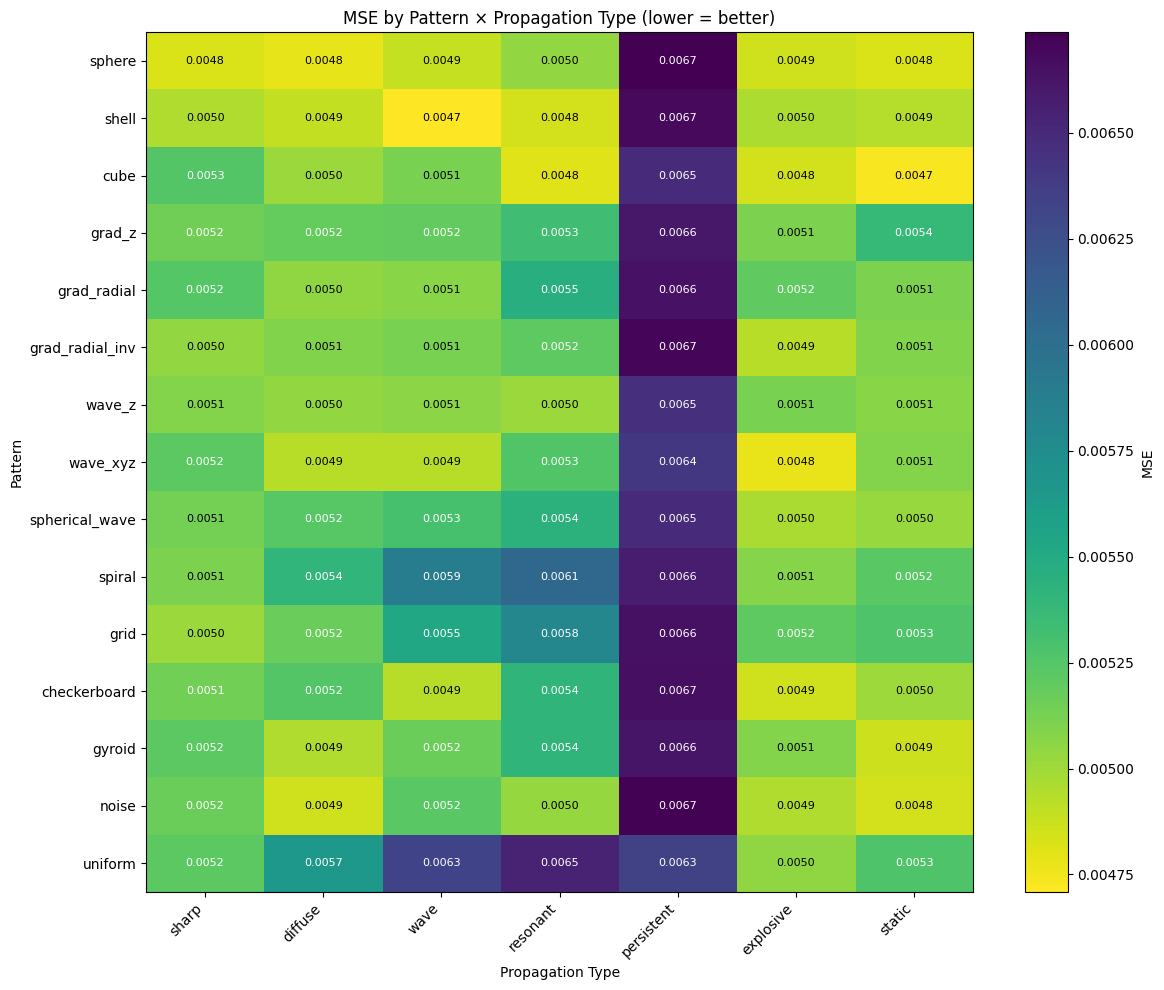

In [11]:
# Create heatmap of results
pattern_names = list(PATTERNS.keys())
prop_names = list(PROPAGATION_TYPES.keys())

# Build MSE matrix
mse_matrix = np.zeros((len(pattern_names), len(prop_names)))
result_dict = {(r.pattern_name, r.prop_name): r.mse for r in search_results}

for i, pname in enumerate(pattern_names):
    for j, propname in enumerate(prop_names):
        mse_matrix[i, j] = result_dict.get((pname, propname), np.nan)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(mse_matrix, cmap='viridis_r', aspect='auto')

ax.set_xticks(range(len(prop_names)))
ax.set_xticklabels(prop_names, rotation=45, ha='right')
ax.set_yticks(range(len(pattern_names)))
ax.set_yticklabels(pattern_names)

ax.set_xlabel('Propagation Type')
ax.set_ylabel('Pattern')
ax.set_title('MSE by Pattern × Propagation Type (lower = better)')

# Add text annotations
for i in range(len(pattern_names)):
    for j in range(len(prop_names)):
        text = f"{mse_matrix[i, j]:.4f}"
        ax.text(j, i, text, ha='center', va='center', fontsize=8,
               color='white' if mse_matrix[i, j] > np.median(mse_matrix) else 'black')

plt.colorbar(im, label='MSE')
plt.tight_layout()
plt.savefig('images/pulse_pattern_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

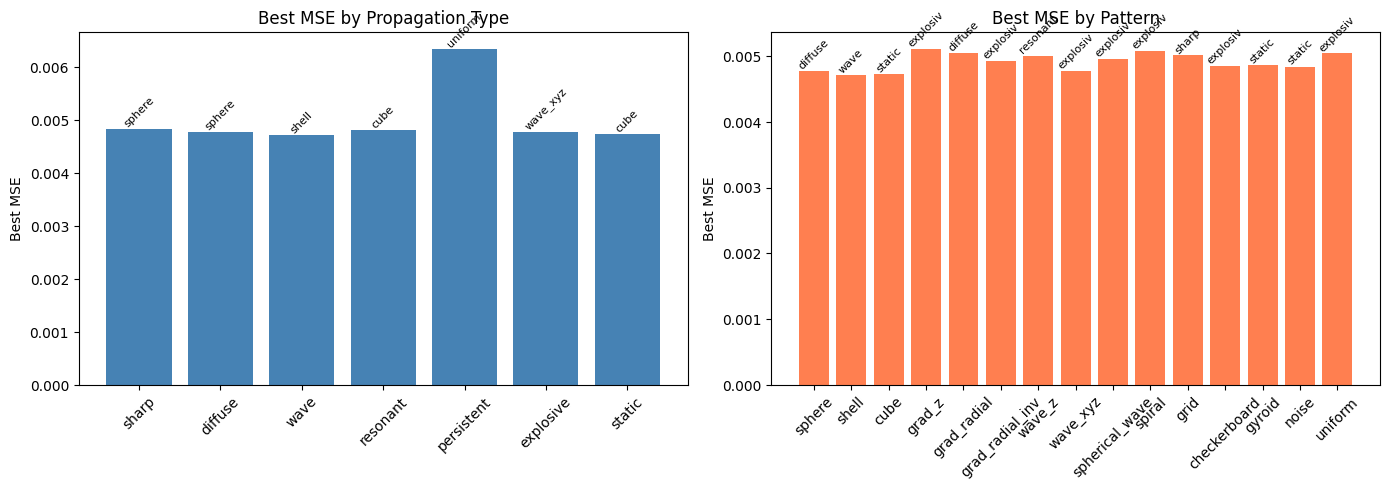

In [12]:
# Best pattern for each propagation type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Group by propagation type
best_per_prop = {}
for prop_name in prop_names:
    prop_results = [r for r in search_results if r.prop_name == prop_name]
    best_per_prop[prop_name] = min(prop_results, key=lambda x: x.mse)

props = list(best_per_prop.keys())
mses = [best_per_prop[p].mse for p in props]
best_patterns = [best_per_prop[p].pattern_name for p in props]

bars = axes[0].bar(props, mses, color='steelblue')
axes[0].set_ylabel('Best MSE')
axes[0].set_title('Best MSE by Propagation Type')
axes[0].tick_params(axis='x', rotation=45)

# Annotate with best pattern
for bar, pattern in zip(bars, best_patterns):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                pattern[:10], ha='center', va='bottom', fontsize=8, rotation=45)

# Group by pattern
best_per_pattern = {}
for pattern_name in pattern_names:
    pattern_results = [r for r in search_results if r.pattern_name == pattern_name]
    best_per_pattern[pattern_name] = min(pattern_results, key=lambda x: x.mse)

patterns = list(best_per_pattern.keys())
mses = [best_per_pattern[p].mse for p in patterns]
best_props = [best_per_pattern[p].prop_name for p in patterns]

bars = axes[1].bar(patterns, mses, color='coral')
axes[1].set_ylabel('Best MSE')
axes[1].set_title('Best MSE by Pattern')
axes[1].tick_params(axis='x', rotation=45)

# Annotate with best propagation
for bar, prop in zip(bars, best_props):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                prop[:8], ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.savefig('images/pulse_pattern_best_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Visualize Best Configuration

Best Configuration:
  Pattern: shell
  Propagation: wave
    - Steps: 8
    - Decay: 0.9
    - Diffusion: 0.6
    - Nonlinearity: tanh


/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_7977/837468109.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


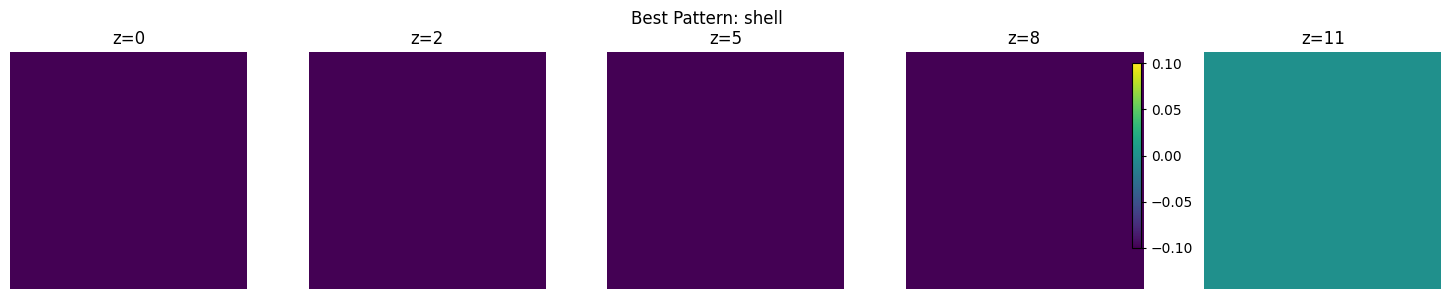

In [13]:
def show_pattern_slices(data, title, n_slices=5):
    """Show 3D data as slices."""
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    fig, axes = plt.subplots(1, n_slices, figsize=(15, 3))
    slice_indices = [int(i) for i in np.linspace(0, data.shape[2]-1, n_slices)]
    
    vmin, vmax = float(data.min()), float(data.max())
    for ax, z in zip(axes, slice_indices):
        im = ax.imshow(data[:, :, z], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'z={z}')
        ax.axis('off')
    
    plt.suptitle(f'{title}')
    plt.colorbar(im, ax=axes, shrink=0.8)
    plt.tight_layout()
    plt.show()


# Show best pattern
best_pattern = PATTERNS[best.pattern_name]
best_prop = PROPAGATION_TYPES[best.prop_name]

print(f"Best Configuration:")
print(f"  Pattern: {best.pattern_name}")
print(f"  Propagation: {best.prop_name}")
print(f"    - Steps: {best_prop.n_steps}")
print(f"    - Decay: {best_prop.decay_rate}")
print(f"    - Diffusion: {best_prop.diffusion_rate}")
print(f"    - Nonlinearity: {best_prop.nonlinearity}")

show_pattern_slices(best_pattern.pattern.data, f"Best Pattern: {best.pattern_name}")

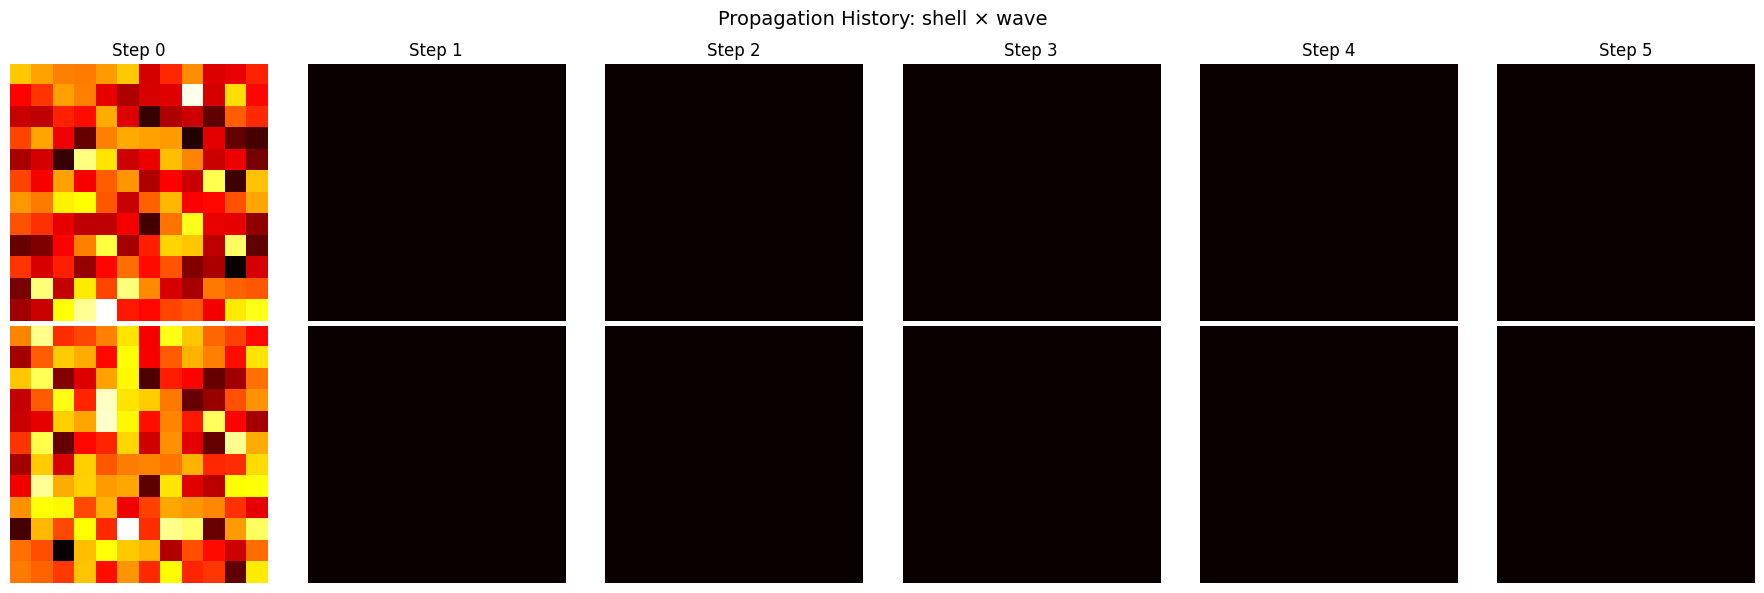

In [14]:
# Visualize propagation through the best pattern
model = PropagationAutoencoder(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    lattice_shape=LATTICE_SHAPE,
    hidden_dim=HIDDEN_DIM,
    pattern=best_pattern.pattern,
    prop_type=best_prop
).to(device)

# Get a sample and visualize propagation
sample = train_data[0:1].to(device)

model.eval()
with torch.no_grad():
    reconstruction, final_state, history = model(sample)

# Show propagation history
n_steps_to_show = min(len(history), 6)
fig, axes = plt.subplots(2, n_steps_to_show, figsize=(18, 6))

z_mid = LATTICE_SHAPE[2] // 2

for i in range(n_steps_to_show):
    state = history[i][0].cpu().numpy().reshape(LATTICE_SHAPE)
    
    # XY slice
    axes[0, i].imshow(state[:, :, z_mid], cmap='hot')
    axes[0, i].set_title(f'Step {i}')
    axes[0, i].axis('off')
    
    # XZ slice
    axes[1, i].imshow(state[:, LATTICE_SHAPE[1]//2, :], cmap='hot')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('XY slice', fontsize=12)
axes[1, 0].set_ylabel('XZ slice', fontsize=12)

plt.suptitle(f'Propagation History: {best.pattern_name} × {best.prop_name}', fontsize=14)
plt.tight_layout()
plt.savefig('images/propagation_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Train Final Model with Best Configuration

In [15]:
# Extended training with best configuration
print(f"Training final model: {best.pattern_name} × {best.prop_name}")
print("=" * 60)

final_model = PropagationAutoencoder(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    lattice_shape=LATTICE_SHAPE,
    hidden_dim=HIDDEN_DIM,
    pattern=best_pattern.pattern,
    prop_type=best_prop
).to(device)

optimizer = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

FINAL_EPOCHS = 100
n_samples = len(train_data)
train_losses = []

final_model.train()
for epoch in tqdm(range(FINAL_EPOCHS), desc="Training"):
    indices = torch.randperm(n_samples)
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, BATCH_SIZE):
        batch_idx = indices[i:i+BATCH_SIZE]
        batch = train_data[batch_idx].to(device)
        
        optimizer.zero_grad()
        reconstruction, _, _ = final_model(batch)
        loss = F.mse_loss(reconstruction, batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    scheduler.step()
    train_losses.append(epoch_loss / n_batches)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.6f}")

print(f"\nFinal loss: {train_losses[-1]:.6f}")

Training final model: shell × wave


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20: Loss = 0.003092
Epoch 40: Loss = 0.002167
Epoch 60: Loss = 0.001746
Epoch 80: Loss = 0.001514
Epoch 100: Loss = 0.001437

Final loss: 0.001437


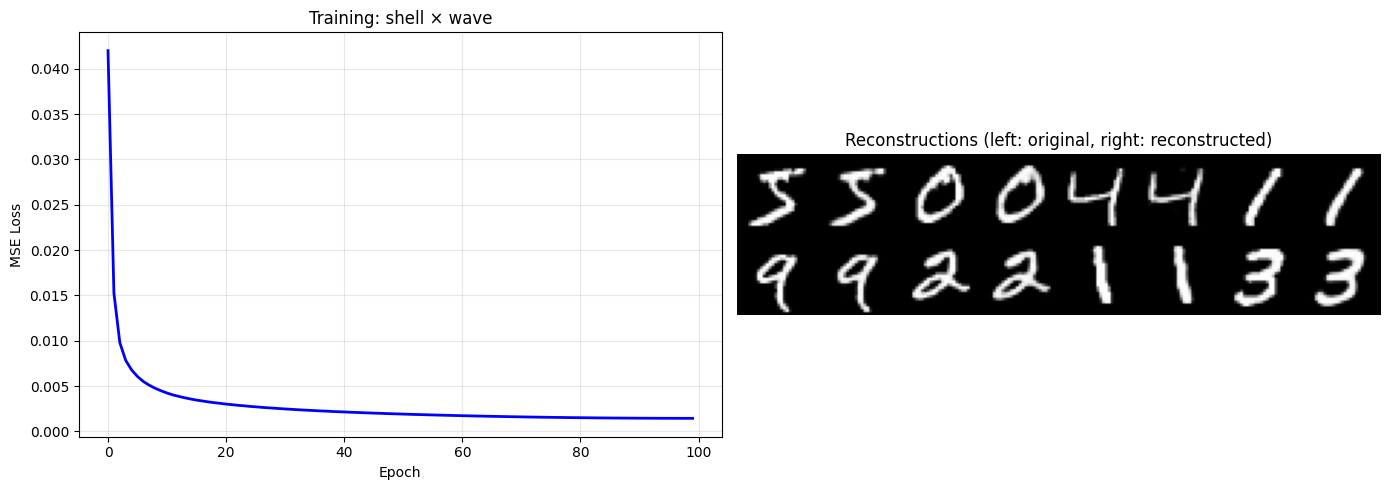

In [16]:
# Plot training curve and reconstructions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training curve
axes[0].plot(train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title(f'Training: {best.pattern_name} × {best.prop_name}')
axes[0].grid(True, alpha=0.3)

# Final reconstructions
final_model.eval()
with torch.no_grad():
    test_samples = train_data[:8].to(device)
    reconstructions, _, _ = final_model(test_samples)

# Show as grid
grid_data = []
for i in range(8):
    orig = test_samples[i].cpu().numpy().reshape(28, 28)
    recon = reconstructions[i].cpu().numpy().reshape(28, 28)
    combined = np.concatenate([orig, recon], axis=1)
    grid_data.append(combined)

grid = np.concatenate(grid_data[:4], axis=1)
grid2 = np.concatenate(grid_data[4:], axis=1)
full_grid = np.concatenate([grid, grid2], axis=0)

axes[1].imshow(full_grid, cmap='gray')
axes[1].set_title('Reconstructions (left: original, right: reconstructed)')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('images/pulse_final_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Save Results

In [19]:
import json

# Save search results
results_data = {
    'config': {
        'lattice_shape': LATTICE_SHAPE,
        'topology': TOPOLOGY,
        'connectivity': CONNECTIVITY,
        'train_epochs': TRAIN_EPOCHS
    },
    'best': {
        'pattern': best.pattern_name,
        'propagation': best.prop_name,
        'mse': best.mse,
        'propagation_config': {
            'n_steps': best_prop.n_steps,
            'decay_rate': best_prop.decay_rate,
            'bounce_strength': best_prop.bounce_strength,
            'diffusion_rate': best_prop.diffusion_rate,
            'self_retention': best_prop.self_retention,
            'nonlinearity': best_prop.nonlinearity
        }
    },
    'top_10': [
        {'pattern': r.pattern_name, 'propagation': r.prop_name, 'mse': r.mse}
        for r in search_results[:10]
    ],
    'all_results': [
        {'pattern': r.pattern_name, 'propagation': r.prop_name, 'mse': r.mse,
         'variance': r.state_variance, 'sparsity': r.state_sparsity}
        for r in search_results
    ]
}

with open('pulse_search_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

# Save best pattern
np.save('best_pulse_pattern.npy', best_pattern.pattern.data)

# Save model
torch.save(final_model.state_dict(), 'best_pulse_model.pt')

print("Saved:")
print("  - pulse_search_results.json")
print("  - best_pulse_pattern.npy") 
print("  - best_pulse_model.pt")

Saved:
  - pulse_search_results.json
  - best_pulse_pattern.npy
  - best_pulse_model.pt


In [ ]:
# Print summary
print("\n" + "=" * 60)
print("PULSE PROPAGATION PATTERN SEARCH SUMMARY")
print("=" * 60)
print(f"\nConfigurations tested: {len(search_results)}")
print(f"  Patterns: {len(PATTERNS)}")
print(f"  Propagation types: {len(PROPAGATION_TYPES)}")
print(f"\nBest configuration:")
print(f"  Pattern: {best.pattern_name}")
print(f"  Propagation: {best.prop_name}")
print(f"  MSE: {best.mse:.6f}")
print(f"\nFinal model loss: {train_losses[-1]:.6f}")


PULSE PROPAGATION PATTERN SEARCH SUMMARY

Configurations tested: 105
  Patterns: 15
  Propagation types: 7

Best configuration:
  Pattern: shell
  Propagation: wave
  MSE: 0.004709

Final model loss: 0.001437
